참고 : https://medium.com/@msmapark2/fcn-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-fully-convolutional-networks-for-semantic-segmentation-81f016d76204

### 컴퓨터 비젼에서 주로 다뤄지는 문제들

- **Classification (분류)**: 인풋에 대해서 하나의 레이블을 예측하는 작업.
AlexNet, ResNet, Xception 등의 모델

- **Localization/Detection (발견)**: 물체의 레이블을 예측하면서 그 물체가 어디에 있는지 정보를 제공. 물체가 있는 곳에 네모를 그리는 등

- YOLO, R-CNN 등의 모델 **Segmentation (분할):** 모든 픽셀의 레이블을 예측
FCN, SegNet, DeepLab 등의 모델

<image src = "http://ataspinar.com/wp-content/uploads/2017/11/deeplearing_types.png">

## Image Segmentation vs. Image classification

- (what) 개 / 고양이 vs. (what + where) 픽셀 단위 구별

- 단순히 사진을 분류하는 것이 아니라, 사진에 있는 모든 픽셀을 해당하는 CLASS로 분류하는 것
- 이미지에 있는 모든 픽셀에 대해 예측하기 때문에 dense prediction이라고도 불린다. 

<img src = "https://miro.medium.com/max/963/1*xWh0LhoDzwyjcxXpnz9lIQ.png">

<img src = "https://miro.medium.com/max/963/1*jHv5C23SLtL3UFeR8VnohQ.png">

                                instance segmentation                   vs.                   sementic segmentation

# FCN 모델

- Fully Convolutional Networks for Semantic Segmentation (FCN)은 sementic segmentation 문제를 위해 제안된 모델

- 기존에 이미지 분류에서 우수한 성능을 보인 CNN 기반 모델 (AlexNet, VGG16, GoogLeNet)을 목적에 맞춰 변형시킨 것


## 1. Convolutionalization

Image classification 모델들은 기본적으로 내부 구조와 상관 없이 모델의 근본적인 목표를 위해 출력층이 Fully-connected (FC) layer로 구성되어 있다.

이러한 구성은 네트워크의 입력층에서 중간부분까지는 ConvNet을 이용하여 영상의 특징을 추출하고 해당 특징들을 출력층 부분에서 FC를 이용해 이미지를 분류하기 위함이다.

<img src = "https://miro.medium.com/max/963/1*8ckDGCdl3YQy1V7sJ0hPTg.png">

그러나, Semantic Segmentation 관점에서는 FC layer가 갖는 한계점이 있다.

### 문제 1. 이미지의 위치 정보가 사라진다.

<img src = "https://miro.medium.com/max/963/1*SbR08aYSbiDX2hadjdOsRw.png">

<img src = "https://miro.medium.com/max/963/1*IZ04YiEdorka6zx-vAzf-g.png">

### 문제 2. 입력 이미지 크기가 고정된다.

Dense layer에 가중치 개수가 고정되어 있기 때문에 바로 앞 레이어의 Feature Map의 크기도 고정되며, 연쇄적으로 각 레이어의 Feature Map 크기와 Input Image 크기 역시 고정된다.

<img src = "https://miro.medium.com/max/963/1*b7GEG3MP6zVmwoeASMQ1AA.png">

이러한 FC-layer의 한계를 보완하기 위해 모든 FC-layer를 Conv-layer로 대체하는 방법을 택했다. VGG16을 예로 살펴보자. 다음과 같이 출력층 부분의 마지막 3 FC-layers를 모두 Conv-layers로 변경한다.

<img src = "https://miro.medium.com/max/963/1*ddf0sJZDitiqVCWdjijzCA.png">

마지막 FC-layer를 채널 차원을 클래스 수에 맞춘 1x1 conv로 변환한다. 이를 통해 위치 정보를 유지할 수 있게 된다. 

아래에서는 첫 번째 fully-connected layer를 (7x7x512) 4096filter conv로 변경하면 가중치의 수가 유지된다.

<img src = "https://miro.medium.com/max/963/1*2IuHjzPjjGXtDU-eAUzxeA.png">

VGG16의 예시

<img src = "https://miro.medium.com/max/963/1*5LhYXkhBg6kwbR1zN5Eg8g.png">

Convolutionalization을 통해 출력 Feature map은 원본 이미지의 위치 정보를 내포할 수 있게 되었다.

그러나 여러 단계의 (convolution + pooling)을 거치게 되면, feature-map의 크기가 줄어들게 된다.

Semantic segmentation의 최종 목적인 픽셀 단위 예측과 비교했을 때, FCN의 출력 Feature map은 너무 coarse(거친, 알맹이가 큰) 하다.

따라서, Coarse map을 원본 이미지 크기에 가까운 Dense map으로 변환해줄 필요가 있다. 적어도 input image size * 1/32 보다는 해상도가 높을 필요가 있다.

## 2. Deconvolution (Upsampling)
Coarse map에서 Dense map을 얻는 방법

### 1) Bilinear Interpolation

<img src = "https://miro.medium.com/max/963/1*GH-pex9uDkeS11wDIJBeTw.png">

<img src = "https://miro.medium.com/max/963/1*EWqK_U7dJtt456g3_kTUjA.png">

<img src = "https://miro.medium.com/max/963/1*1ItRe38ocUZLKJEkGHUh4Q.png">

Bilinear interpolation은 이러한 1차원의 Linear interpolation을 2차원으로 확장한 것

<img src = "https://miro.medium.com/max/963/1*arKsBkAMZG-EDF2WIVBUNw.png">

Bilinear interpolation을 통해 Feature map의 빈 영역을 추정

<img src = "https://miro.medium.com/max/963/1*AmGkUff5wN0o7ubdIfc8DQ.png">

### 2) Backwards convolution

Stride가 2이상인 Convolution 연산의 경우 입력 이미지에 대해 크기가 줄어든 특징맵을 출력한다. 이것은 Down-sampling에 해당한다. 

Convolution 연산을 반대로 할 경우 자연스럽게 Up-sampling 효과를 볼 수 있다. 또한, 이 때 사용하는 Filter의 가중치 값은 학습 파라미터에 해당한다.

이렇게 되면, 경우에 따라 bilinear한 필터를 학습할 수도 있고, non-linear upsampling도 가능해진다.

<img src = "https://miro.medium.com/max/963/1*hsfu-pv0tyGrN3rHi8njyA.png">

<img src = "https://miro.medium.com/max/963/1*gtBk1yTapyFzvh00DUkGBA.png">

FCNs에서 Bilinear interpolation과 Backwards convolution 두 가지 방법을 사용하여 Coarse Feature map으로부터 Dense prediction을 구했다. 초기 Segmentation을 위한 모델은 VGG모델을 컨볼루션화한 구조에 Bilinear interpolation 작업을 더함으로써 얻을 수 있다.

그러나, Interpolation을 통해 coarse map에서 dense map을 도출할 수 있었지만 근본적으로 feature map의 크기가 너무 작기 때문에 예측된 dense map의 정보는 여전히 거칠수 밖에 없다.

<img src = "https://miro.medium.com/max/963/1*67WIJexGu6DMmiWrQ2eUNw.png">

### 3) Skip Architecture

- 보다 정교한 Segmentation을 위해서 추가적인 작업

- Deep & Coarse(추상적인) 레이어의 의미적(Semantic) 정보와 Shallow & fine 층의 외관적(appearance) 정보를 결합한 Skip architecture

<img src = "https://miro.medium.com/max/963/1*pbEMiRkXz65ejneuuToK3g.png">

시각화 모델을 통해 입력 이미지에 대해 얕은 층에서는 주로 직선 및 곡선, 색상 등의 낮은 수준의 특징에 활성화되고, 깊은 층에서는 보다 복잡하고 포괄적인 개체 정보에 활성화된다는 것을 확인할 수 있다.

또한 얕은 층에선 local feature를 깊은 층에선 global feature를 감지한다고 볼 수 있다.

연구진은 이러한 직관을 기반으로 앞에서 구한 Dense map에 얕은 층의 정보를 결합하는 방식으로 Segmentation의 품질을 개선하였다.

<img src = "https://miro.medium.com/max/963/1*-1hOIxlnFn3qd7n5JEgzFg.png">

FCN-16s는 pool5의 결과를 2배 upsample한 결과와 pool4의 결과를 합쳐, 그 결과를 16배 upsample하는 방식이다.

<img src = "https://miro.medium.com/max/963/1*1r-KVNqt9V7JiDT-zyOEAQ.png">

FCN-8s는 FCN-16s의 중간 결과를 2배 upsample한 결과와 pool3에서의 예측을 합친 것을 8배 upsample하는 방식이다.

<img src = "https://miro.medium.com/max/963/1*OXv6w9LaxEOHNhO18A8Zbg.png">

## 정리

- FCNs은 기존의 딥러닝 기반 이미지 분류를 위해 학습이 완료된 모델의 구조를 Semantic Segmentation 목적에 맞게 수정하여 Transfer learning 하였다.

- Convolutionalized 모델을 통해 예측된 Coarse map을 원본 이미지 사이즈와 같이 세밀(Dense)하게 만들기 위해 Up-sampling을 수행하였다.

- 또한 Deep Neural Network에서 얕은 층의 Local 정보와 깊은 층의 Semantic 정보를 결함하는 Skip architecture를 통해 보다 정교한 Segmantation 결과를 얻을 수 있었다.

참고: https://www.kaggle.com/abhinavsp0730/semantic-segmentation-by-implementing-fcn

## Oxford-IIIT pet dataset

37 category pet image dataset with roughly 200 images for each class

In [ ]:
# Installing tensorflow datasets
!pip install -U tfds-nightly

In [2]:
# importing the libraries
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
# downloading the dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVHGEW8/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVHGEW8/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


### - 전처리

In [4]:
# function to normalize the dataset,i.e the pixel value ranges from 0-1
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

이미지가 [0,1]로 정규화된다. 

분할 마스크의 픽셀에 {1, 2, 3}이라는 레이블이 붙는데, 편의성을 위해 분할 마스크에서 1을 빼서 레이블이 {0, 1, 2}이 되도록 한다. 

또한 이미지를 뒤집는 간단한 augmentation을 수행한다.

In [5]:
# resizing the train dataset image to H x W = 128 x 128
# performing image augmentation to increase the dataset size
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
# resizing the test dataset image to H x W = 128 x 128
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
# defining some hyperparameters
TRAIN_LENGTH = info.splits['train'].num_examples
BUFFER_SIZE = 1000
BATCH_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
# defining the input pipeline
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

### - 이미지 예제와 데이터 세트에서 대응하는 마스크를 확인

In [9]:
# function for showing sample images and its mask from the dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

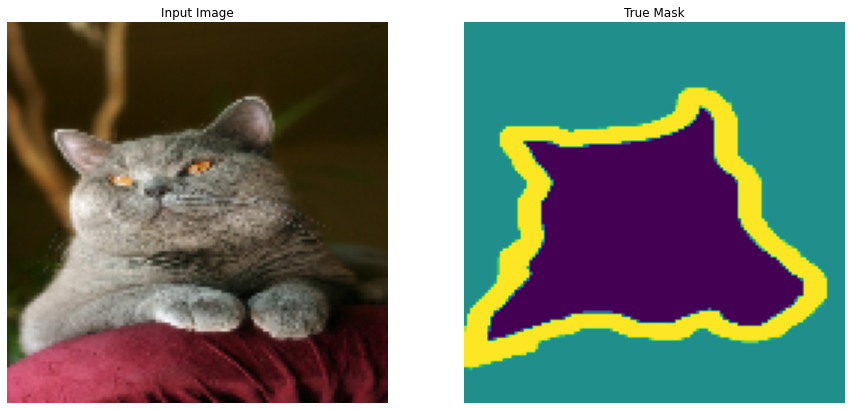

In [10]:
# train.take(3) method takes the first element f
for image, mask in train.take(3):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### - 모델 정의

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [12]:
def fcn(image_size, ch_in=3, ch_out=3):
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  
    f4 = vgg16.get_layer('block4_pool').output  
    f5 = vgg16.get_layer('block5_pool').output  

    # Replacing VGG dense layers by convolutions:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1, f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8,
                              padding='same', activation=None)(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

In [13]:
# defining the tensorflow distribute strategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [14]:
# calling the model inside the scope
with strategy.scope():
  model = fcn(image_size=(128, 128))
  # compiling the model with the optimizer, loss function and acc metrics
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


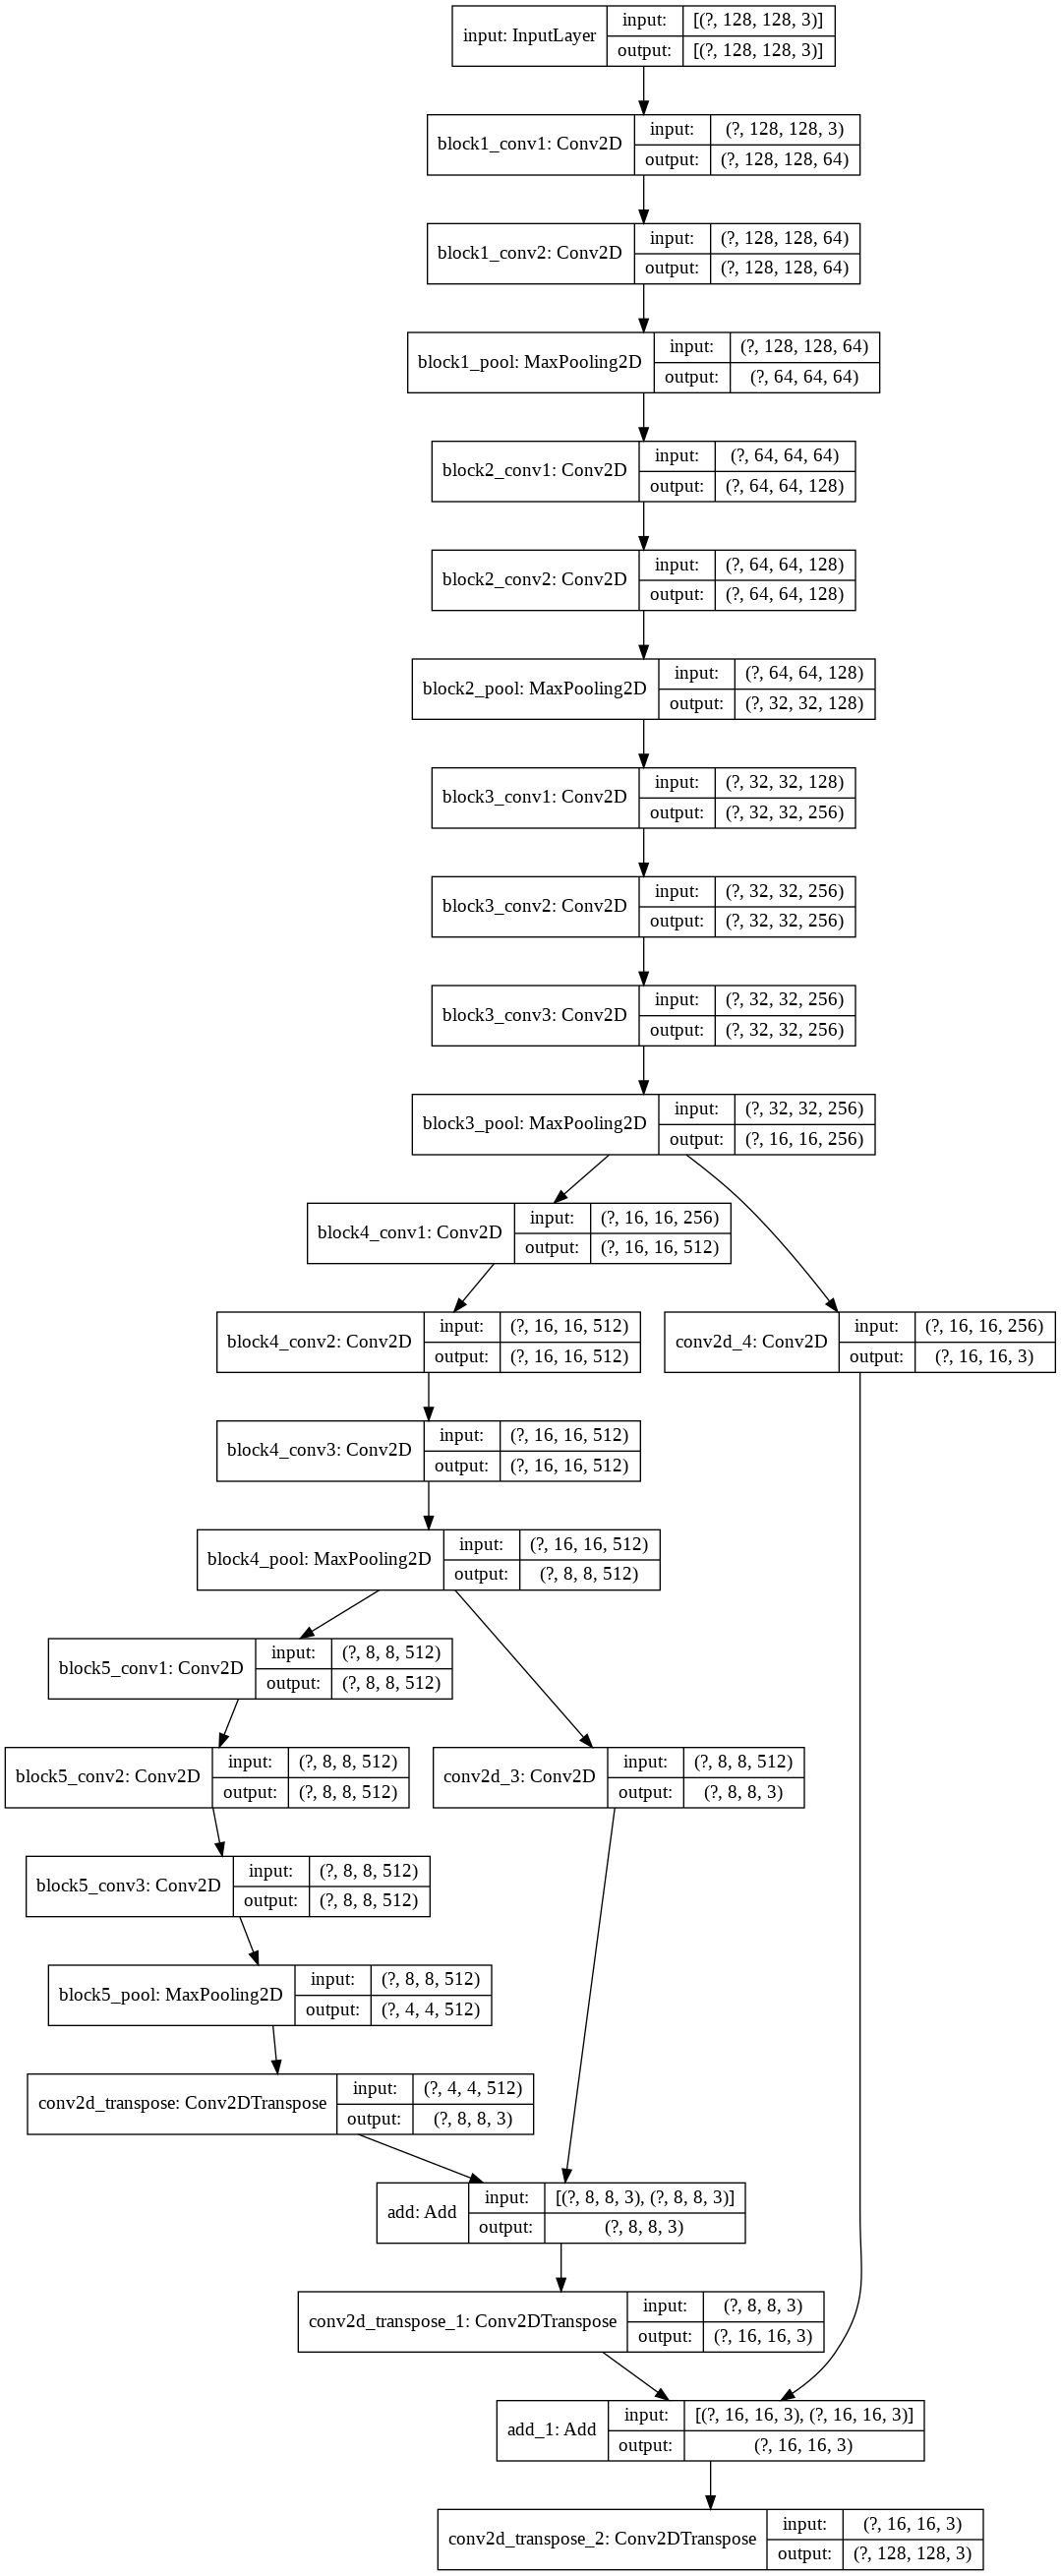

In [15]:
# let's see how our FCN implemented model looks like
# does it looks like the architecture fig above?
tf.keras.utils.plot_model(model, show_shapes=True)

### - 예측 및 확인

In [16]:
# function to create the mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [17]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


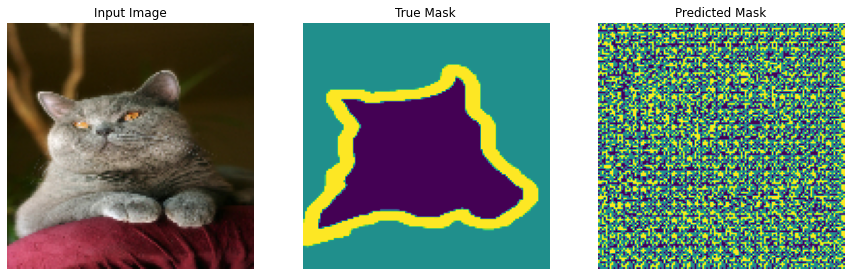

In [18]:
# 훈련 전 예측
# Let's see a sample of input image it's true mask and what our model is predicted given the input image
show_predictions()

In [19]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)

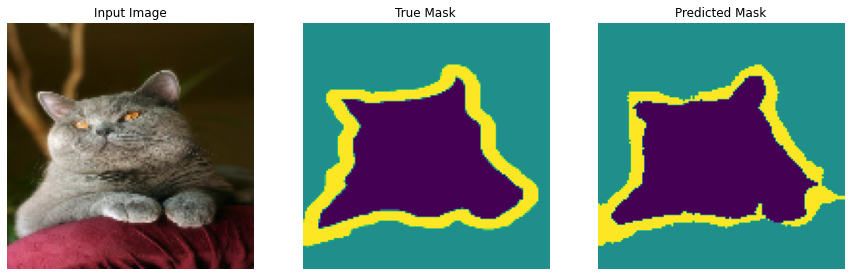


Sample Prediction after epoch 50

28/28 [==============================] - 17s 601ms/step - loss: 0.2070 - accuracy: 0.9095 - val_loss: 0.3221 - val_accuracy: 0.8807


In [20]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), reduce_lr, early_stopping])

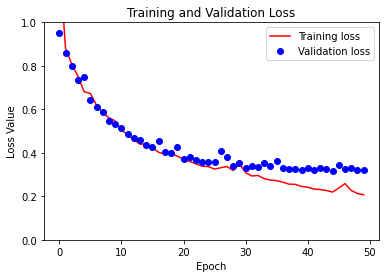

In [21]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

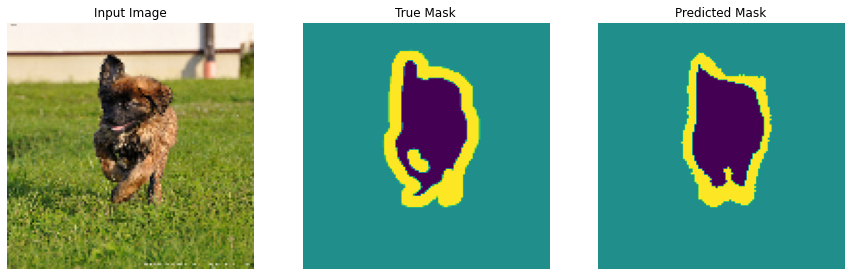

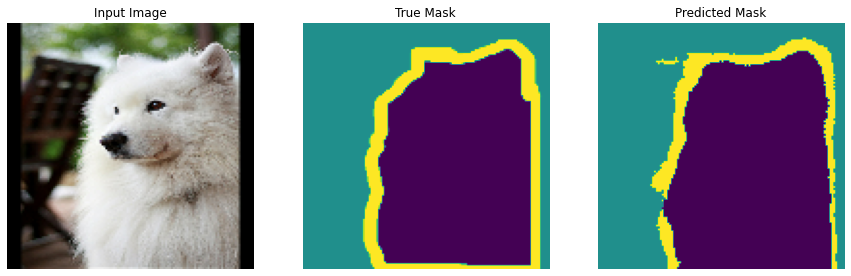

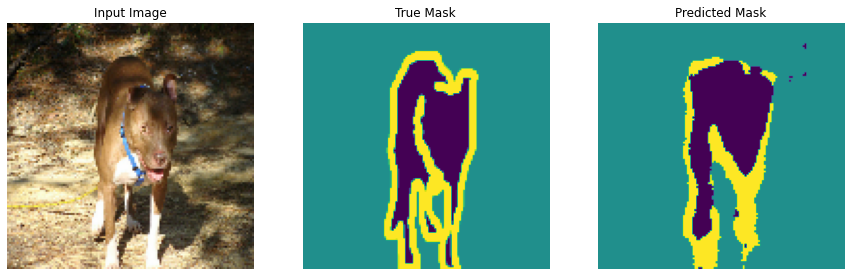

In [22]:
show_predictions(test_dataset, 3)

### FCN의 문제점

- 사전에 미리 정한 receptive field를 사용하기 때문에 너무 작은 object가 무시되거나, 큰 물체를 여러 개의 작은 물체로 인식하거나 일관되지 않은 결과가 나올 수 있다.

- 여러 단의 'conv + pooling'을 거치면서 해상도가 줄어들고, 줄어든 해상도를 다시 upsampling을 통해 복원하는 방식을 사용하기 때문에 detail이 사라지거나 과도하게 smoothing 효과에 의해 결과가 아주 정밀하지는 못하다.

<img src = "https://modulabs-biomedical.github.io/assets/images/posts/2018-01-03-Learning_Deconvolution_Network_for_Semantic_Segmentation/fig1.jpg">

FCN에서는 CNN의 결과를 입력 이미지의 원래 차원으로 확대(upsampling)하는 데에 deconvolution을 사용했다. 

FCN의 단점을 해결하기 위해 deconvolution 시 차원을 유지하는 방법으로, CNN(논문에서 사용한 건 VGG-16)의 convolution만큼 레이어 숫자를 늘린다. 결과적으로 거울에 비춘 모양이 된다.

CNN으로 인해 원래 이미지보다 축소된 차원 크기는 unpooling으로 복원한다. 여기서 unpooling이란 CNN의 max pooling 시의 위치 정보를 기억했다가, 원래 위치 그대로 복원해주는 작업이다.

<img src = "https://modulabs-biomedical.github.io/assets/images/posts/2018-01-03-Learning_Deconvolution_Network_for_Semantic_Segmentation/fig2.jpg">

<img src = "https://modulabs-biomedical.github.io/assets/images/posts/2018-01-03-Learning_Deconvolution_Network_for_Semantic_Segmentation/fig4.jpg">